In [197]:
import os
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt

In [198]:
set_model_results = {}
PATH_NAIVE = './output/1-dictionary-naive-search'
PATH_CMS = './output/2-count-min-sketch+bloom_freq'
PATH_DEEZY = './output/3-deezy-alg'
for i in range(10):
    set_model_results[f"naive_{i}"] = pd.read_csv(f"{PATH_NAIVE}/dataset_{i}.csv", index_col=0)
    set_model_results[f"cms_{i}"] = pd.read_csv(f"{PATH_CMS}/dataset_{i}.csv", index_col=0)
    set_model_results[f"deezy_{i}"] = pd.read_csv(f"{PATH_DEEZY}/dataset_{i}.csv", index_col=0)

In [199]:
dict_matches = {}
list_indexes = list(set_model_results['naive_0'].index.values)
for dataset_key, dataset in set_model_results.items():
    dict_matches[dataset_key] = dataset.loc[:,'matched_words']
pd_matches = pd.DataFrame(dict_matches, index=list_indexes)

pd_matches

,naive_0,cms_0,deezy_0,naive_1,cms_1,deezy_1,naive_2,cms_2,deezy_2,naive_3,...,deezy_6,naive_7,cms_7,deezy_7,naive_8,cms_8,deezy_8,naive_9,cms_9,deezy_9
I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
an,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
and,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apple,appeal,appeal,"{'papel', 'appealed'}",appeal,appeal,{'appealed'},appeal,appeal,"{'citadel', 'appice'}","{'appell', 'appeal', 'appel'}",...,"{'applied', 'appealed'}",appeal,appeal,"{'cappelen', 'appealed'}",appeal,appeal,"{'apoel', 'papel'}",appeal,appeal,"{'appealed', 'padel'}"
banana,"{'bangunan', 'lannan', 'bandanna', 'bananas'}","{'lannan', 'bangunan', 'bandanna', 'bananas'}","{'nabāto', 'bandanna'}","{'hannan', 'ananta', 'banana'}","{'hannan', 'ananta', 'banana'}","{'banana', 'nana'}","{'anna', 'banana'}","{'anna', 'banana'}","{'banana', 'three-month'}","{'bannon', 'annan', 'bandanas', 'bafana'}",...,"{'banana', 'bandwidth'}","{'lannan', 'ananda'}","{'ananda', 'lannan'}","{'rana', 'anandamath'}","{'banana', 'anna', 'nana', 'bandana'}","{'nana', 'anna', 'banana', 'bandana'}","{'bandana', 'nana'}","{'gannan', 'bandanna', 'qiannan', 'nana', 'anna'}","{'gannan', 'nana', 'qiannan', 'anna', 'bandanna'}","{'bandanna', 'nana'}"
don't,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
error,"{'error', 'rnrhof', 'rirwof', 'errors'}","{'error', 'rnrhof', 'rirwof', 'errors'}","{'error', 'r'}",error,error,{'error'},error,error,{'error'},error,...,"{'error', 'redo'}","{'error', 'errol', 'errors'}","{'error', 'errol', 'errors'}","{'error', 'redmond'}","{'error', 'terror', 'errors'}","{'error', 'terror', 'errors'}",{'error'},"{'error', 'errors'}","{'error', 'errors'}","{'error', 'fervor'}"
have,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hope,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
pd_matches = pd_matches.loc[pd_matches[pd_matches != 'NaN'].any(axis=1)]

In [201]:
pd_matches

,naive_0,cms_0,deezy_0,naive_1,cms_1,deezy_1,naive_2,cms_2,deezy_2,naive_3,...,deezy_6,naive_7,cms_7,deezy_7,naive_8,cms_8,deezy_8,naive_9,cms_9,deezy_9
apple,appeal,appeal,"{'papel', 'appealed'}",appeal,appeal,{'appealed'},appeal,appeal,"{'citadel', 'appice'}","{'appell', 'appeal', 'appel'}",...,"{'applied', 'appealed'}",appeal,appeal,"{'cappelen', 'appealed'}",appeal,appeal,"{'apoel', 'papel'}",appeal,appeal,"{'appealed', 'padel'}"
banana,"{'bangunan', 'lannan', 'bandanna', 'bananas'}","{'lannan', 'bangunan', 'bandanna', 'bananas'}","{'nabāto', 'bandanna'}","{'hannan', 'ananta', 'banana'}","{'hannan', 'ananta', 'banana'}","{'banana', 'nana'}","{'anna', 'banana'}","{'anna', 'banana'}","{'banana', 'three-month'}","{'bannon', 'annan', 'bandanas', 'bafana'}",...,"{'banana', 'bandwidth'}","{'lannan', 'ananda'}","{'ananda', 'lannan'}","{'rana', 'anandamath'}","{'banana', 'anna', 'nana', 'bandana'}","{'nana', 'anna', 'banana', 'bandana'}","{'bandana', 'nana'}","{'gannan', 'bandanna', 'qiannan', 'nana', 'anna'}","{'gannan', 'nana', 'qiannan', 'anna', 'bandanna'}","{'bandanna', 'nana'}"
error,"{'error', 'rnrhof', 'rirwof', 'errors'}","{'error', 'rnrhof', 'rirwof', 'errors'}","{'error', 'r'}",error,error,{'error'},error,error,{'error'},error,...,"{'error', 'redo'}","{'error', 'errol', 'errors'}","{'error', 'errol', 'errors'}","{'error', 'redmond'}","{'error', 'terror', 'errors'}","{'error', 'terror', 'errors'}",{'error'},"{'error', 'errors'}","{'error', 'errors'}","{'error', 'fervor'}"
jerusalem,jerusalem,jerusalem,"{'jerusalem', 'describes'}",jerusalem,jerusalem,"{'veljanovski', 'jerusalem'}",jerusalem,jerusalem,"{'jerisheh', 'jerusalem'}",jerusalem,...,{'jerusalem'},jerusalem,jerusalem,"{'déclais', 'jerusalem'}",jerusalem,jerusalem,"{'jerisheh', 'jerusalem'}",jerusalem,jerusalem,"{'jerusalem', 'describes'}"
lemon,lemon,lemon,"{'lemon', 'leonie'}","{'leone', 'leon', 'lemmon', 'lemon'}","{'lemmon', 'leon', 'lemon', 'leone'}","{'leone', 'llwyndyrys'}","{'leone', 'lemon'}","{'lemon', 'leone'}","{'leone', 'leonard'}","{'leone', 'lemond'}",...,"{'leone', 'lemmers'}","{'leone', 'lone', 'lemmon', 'lemon'}","{'lemmon', 'lone', 'lemon', 'leone'}","{'leone', 'lemmon'}","{'leone', 'leon', 'lone'}","{'leon', 'lone', 'leone'}","{'leone', 'lermond'}",leone,leone,"{'leone', 'leonards'}"
london,london,london,"{'london', 'longwy'}",london,london,"{'olof', 'london'}",london,london,{'london'},london,...,"{'london', 'dudgeon'}",london,london,{'london'},london,london,{'london'},london,london,{'london'}
pear,paper,paper,"{'parker', 'parameter'}","{'pater', 'paper', 'pager'}","{'paper', 'pater', 'pager'}","{'parker', 'parameter'}",paper,paper,"{'parker', 'parameter'}",paper,...,"{'parker', 'parameter'}","{'pajer', 'paper'}","{'paper', 'pajer'}","{'parker', 'parameter'}",paper,paper,"{'parker', 'parameter'}",paper,paper,"{'parker', 'parameter'}"
please,please,please,"{'settles', 'spieletester.com'}","{'please', 'leases'}","{'please', 'leases'}","{'settles', ""stallion's""}",please,please,"{'safeties', 'peeresses'}",please,...,"{'pleas', 'peeresses'}",please,please,"{'spiders', 'lipstick'}",please,please,{'settles'},please,please,"{'settles', 'tickets'}"
possible,possible,possible,"{'ps', 'pose'}",possible,possible,"{'spoiling', 'superimposed'}",possible,possible,"{'pooja', 'superimposed'}",possible,...,"{'postulates', 'superimposed'}",possible,possible,"{'polish–lithuanian', 'superimposed'}",possible,possible,"{'polish–lithuanian', 'pose'}",possible,possible,"{'pose', 'superimposed'}"
wanna,NaN,NaN,NaN,NaN,NaN,NaN,"{'wanna', 'anna'}",NaN,"{'wanna', 'with'}","{'wanna', 'anna'}",...,"{'hanna', 'hyena'}","{'wanna', 'anna'}",NaN,"{'hanna', 'wanna'}","{'wannabe', 'anna'}","{'wannabe', 'anna'}","{'hanna', 'hyena'}","{'anna', 'hanna', 'ann'}","{'hanna', 'ann', 'anna'}","{'think', 'with'}"


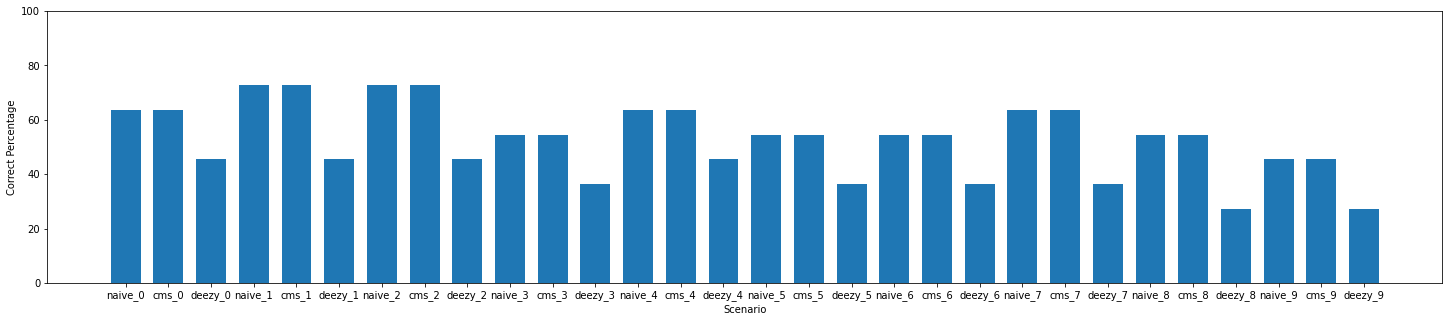

In [202]:
diff_series = {}
original_words = list(pd_matches.index.values)
diff_matches_all = []
for series_name, series in pd_matches.items():
  #print(list(series.index))
  diff_matches = [{word:series[word]} for word in list(series.index)]
  diff_matches_all.append(diff_matches)
  diff_matches = [{word:series[word]} for word in list(series.index) if 
       (type(series[word]) == str and not series[word].startswith('{') and word != series[word]) or
       (type(series[word]) == str and series[word].startswith('{') and word not in [re.sub(r'\W+', '', subword) for subword in series[word].split(",")])]
  diff_series[series_name] = 100 * (1 - (len(diff_matches) / len(series.values)))
diff_series_df = pd.Series(diff_series)
plt.figure(figsize=(25, 5))  # width:20, height:3
plt.bar(diff_series.keys(), diff_series.values(), align='center', width=0.7)
plt.xlabel('Scenario')
plt.ylabel('Correct Percentage')
ax = plt.gca()
ax.set_ylim([0, 100])
plt.show()

In [203]:
dict_diffes = {}
for word in original_words:
    dict_diffes[word] = []

for diff_match in diff_matches_all:
    for diff in diff_match:
        diff_match_key = list(diff.keys())[0]
        diff_match_value = list(diff.values())[0]
        if type(diff_match_value) != str:
            dict_diffes[diff_match_key] = []
        elif not diff_match_value.startswith('{'):
            dict_diffes[diff_match_key].append(diff_match_value)
        else:
            diff_match_values = [re.sub(r'\W+', '', subword) for subword in diff_match_value.split(",")]
            dict_diffes[diff_match_key].extend(diff_match_values)
            
# Unique parameters
dict_diffes = {k: set(v) for k, v in dict_diffes.items()}
dict_diffes
dict_diffes_max_len = max(len(v) for k, v in dict_diffes.items())
dict_diffes_new = {k: ['---' for i in range(dict_diffes_max_len)] for k, v in dict_diffes.items()}
for k, v in dict_diffes_new.items():
  for idx, item in enumerate(dict_diffes[k]):
      dict_diffes_new[k][idx] = item
dict_diffes_new

dict_diffes_df = pd.DataFrame(dict_diffes_new)
dict_diffes_df

,apple,banana,error,jerusalem,lemon,london,pear,please,possible,wanna,watermelon
0,applied,bandanna,perro,veljanovski,lemmon,longwy,paper,spiders,polishlithuanian,wanna,waterman
1,appice,anynana,rnrhof,describe,leon,olof,pajer,leases,postulates,wannabe,watermelon
2,appeal,anhydrous,R,jetstream,llwyndyrys,dudgeon,parameter,pleasures,pivoxazepam,hyena,trawled
3,appell,bandwidth,errol,jersey,leonie,london,practiquer,spieletestercom,pooja,anna,ra
4,citadel,qiannan,redmond,jerusalem,lemond,---,parker,settlers,pose,ann,waterloo
5,lappel,anandamath,error,describes,leonards,---,pager,peeresses,subtypes,think,warren
6,apoel,bandana,r,realm,leonard,---,pater,safeties,ps,with,qara
7,appel,bangunan,terror,jerisheh,lemmers,---,---,pleased,spoiling,hanna,weathermen
8,papel,bafana,errors,jeremy,leone,---,---,tickets,suppressed,---,rhetoric
9,cappelen,nabāto,formed,déclais,lemmons,---,---,stallions,superimposed,---,wartime


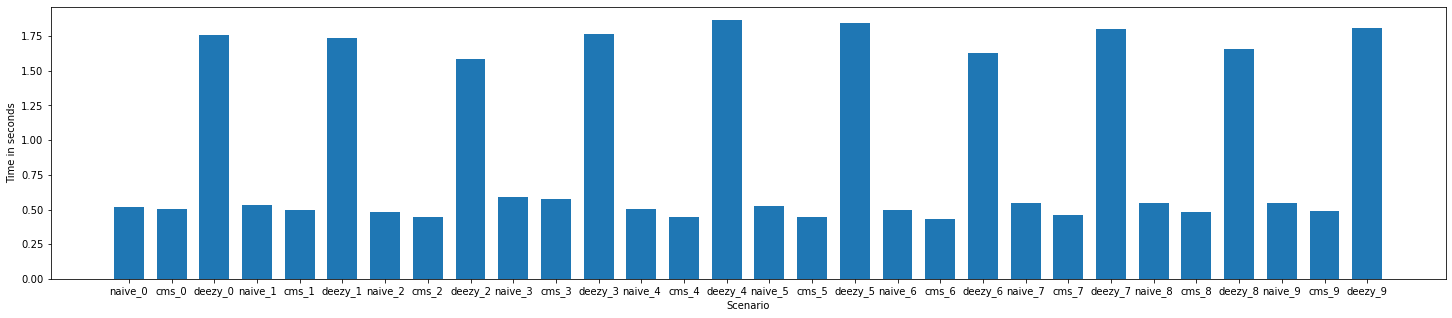

In [204]:
dict_times = {}
list_indexes = list(set_model_results['naive_0'].index.values)
for dataset_key, dataset in set_model_results.items():
    dict_times[dataset_key] = dataset.iloc[0]['time_sec']
pd_times = pd.DataFrame(dict_times, index=[0])

plt.figure(figsize=(25, 5))  # width:20, height:3
plt.bar(pd_times.columns, pd_times.iloc[0], align='center', width=0.7)
plt.xlabel('Scenario')
plt.ylabel('Time in seconds')
ax = plt.gca()
plt.show()